# Imports

In [1]:
import sys
import matplotlib.pyplot as plt
import warnings
import torch

warnings.filterwarnings("ignore")
sys.path.append('../../')
sys.path.append("/home/xinqiao/m3_learning/m3_learning/src")

In [2]:
# For the notebook to work you must have m3_learning installed
# pip install m3_learning
%load_ext autoreload
%autoreload 2 

In [3]:
from m3_learning.viz.printing import printer
from m3_learning.viz.style import set_style
from m3_learning.nn.Bright_Field_NN.Dataset import Bright_Field_Dataset
from m3_learning.nn.Bright_Field_NN.Viz import Viz
from m3_learning.nn.Bright_Field_NN.Autoencoder import ConvAutoencoder
from m3_learning.viz.layout import layout_fig, labelfigs

# Specify the filename and the path to save the file
save_path = './../../../Data/2023_Bright_Field'
fig_path = save_path.replace("Data", "Figures") + '/'

# builds the printer object
printing = printer(basepath=fig_path,fileformats=['png'])

# Set the style of the plots
set_style("printing")

2023-06-20 09:36:15.031032: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 09:36:15.175952: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-20 09:36:15.702800: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/xinqiao/anaconda3/envs/m3/lib/python3.9/site-packages/cv2/../../lib64:
2023-06-20 09:36:15.702874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'lib

printing set for seaborn


In [4]:
# defines Dataset object using images from specified folder
dset = Bright_Field_Dataset(f'{save_path}/Annealed','Annealed_results','Anneal',verbose=False)

# list  paths to image data
# dset.list_imgs()

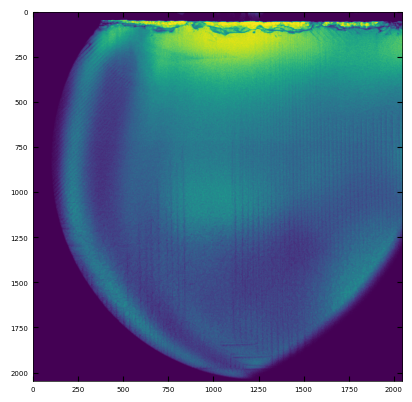

In [5]:
# extract array of image at rampdown, 50 deg celsius
im = dset.get_raw_img('Ramp_Down',"50")
plt.imshow(im)
plt.show()

In [6]:
# Write image data to h5 file
# dset.write_h5(200,300,1400,name='Anneal')

In [7]:
# customize window parameters
window_parameters = {'fft_mode': 'abs',
                    'mode': 'fft',
                    'window_size_x': 400,
                    'window_size_y': 400,
                    'window_step_x': 200,
                    'window_step_y': 200,
                    'zoom_factor': 2}

# Write windows
# wins = dset.write_windows(window_parms=window_parameters,overwrite=False)

## Visualization

In [8]:
# create vizualizer object
viz = Viz(dset,printer=printing)

# add scalebar
viz.scalebar_ = {"width": 273.4, "scale length": 50, "units": "nm"}


./../../../Figures/2023_Bright_Field/Ramp_Up_23_raw.png


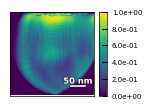

In [9]:
# view raw image
img_name = ['Ramp_Up','23']
viz.view_raw(img_name)

0 [0, 400, 0, 400]


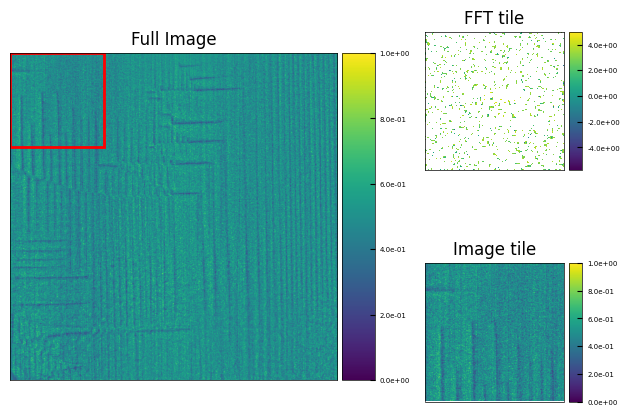

In [10]:
# view windows
viz.view_window(0,0,0)

# Training

In [5]:
# defined model parameters
encoder_step_size = [dset.get_shape('windows/windows_logdata')[-2],
                     dset.get_shape('windows/windows_logdata')[-1]]
pooling_list = [4,4,2]
decoder_step_size = [8,8]
upsampling_list = [2,2,4]
embedding_size = 8
conv_size = 128
batch_size = 1

# set device to load model
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"

# define model
model = ConvAutoencoder(
    encoder_step_size=encoder_step_size,
    pooling_list=pooling_list,
    decoder_step_size=decoder_step_size,
    upsampling_list=upsampling_list,
    embedding_size=embedding_size,
    conv_size=conv_size,
    device=device,
    learning_rate=3e-5,
)

In [6]:
# h.close()

In [7]:
# set retrain parameter
train = True
h = dset.open_combined_h5()

if train:
    model.Train(
        data = h['windows']['windows_logdata'][:],
        coef_1=1e-5,
        epochs=2,
        with_scheduler=False,
        folder_path="Domain_Weights",
        batch_size=256,
    )
else:
    model.load_weights(
        f"{save_path}/11.23_log_epoch_0376_coef_1e-05_trainloss_0.1362.pkl"
    )
h.close()

  0%|          | 0/7 [02:32<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 23.64 GiB total capacity; 21.62 GiB already allocated; 387.50 MiB free; 22.05 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [30]:
h.close()

In [90]:
h.close()